In [1]:
import os

from scipy import stats
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import yaml
try:
    from yaml import CLoader as Loader
except ImportErorr:
    from yaml import Loader

In [2]:
# Set plot size
factor = 1.2
default_dpi = mpl.rcParamsDefault['figure.dpi']
mpl.rcParams['figure.dpi'] = default_dpi*factor

In [3]:
# Folder for data files
data_dir = "data"
# Config file name
cfg_name = "config.yaml"
# Data file name
data_name = ["sps3_2.csv"]

cfg_path = os.path.join(data_dir, cfg_name)

# Read config
with open(cfg_path, "r") as f:
    cfg = yaml.load(f, Loader=Loader)
    
# Read data
data_df_list = []
for n in data_name:
    data_path = os.path.join(data_dir, n)
    data_df_list.append(pd.read_csv(data_path))
data = pd.concat(data_df_list, ignore_index=True)
    

data["I_in"] = data["I_in"] * 1e6
data["I_meas"] = data["V_i"] / cfg["r_sense"] / cfg["gain"] * 1e6
data["V_meas"] = data["V_2x"] / 2.

data

,V_in,I_in,V_i,V_2x,I_meas,V_meas
0,0.100064,50.57431,0.106952,0.207040,42.952610,0.103520
1,0.110068,54.64605,0.116306,0.227016,46.709237,0.113508
2,0.120071,58.71482,0.126679,0.246553,50.875100,0.123276
3,0.130085,62.79028,0.135287,0.268302,54.332129,0.134151
4,0.140084,66.85960,0.145733,0.287247,58.527309,0.143623
...,...,...,...,...,...,...
85,0.949957,396.34050,0.962366,1.902193,386.492369,0.951097
86,0.959960,400.41030,0.973850,1.921795,391.104418,0.960897
87,0.969961,404.47940,0.983764,1.941175,395.085944,0.970588
88,0.979967,408.55170,0.992477,1.961059,398.585141,0.980530


In [4]:
def plot_accuracy(x, y):
    """Plots a graph showing the accuracy of measurements y to ideal values x
    
    Parameters
    ----------
    x : Series
        True values
    y : Series
        Measured values
        
    Returns
    -------
    fig, ax
        Matplotlib figure, same format as plt.subplots
    """
    
    fig, ax = plt.subplots()
    ax.plot(x, y / x)
    ax.axhline(y=1, linestyle=':', color='k', linewidth='3')
    ax.grid()
    
    return (fig, ax)

Text(0, 0.5, 'Relative Measurement (V/V)')

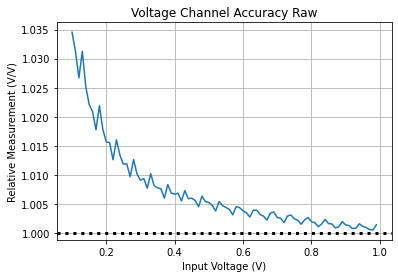

In [5]:
fig, ax = plot_accuracy(data["V_in"], data["V_meas"])

ax.set_title("Voltage Channel Accuracy Raw")
ax.set_xlabel("Input Voltage (V)")
ax.set_ylabel("Relative Measurement (V/V)")

Text(0, 0.5, 'Relative Measurement (A/A)')

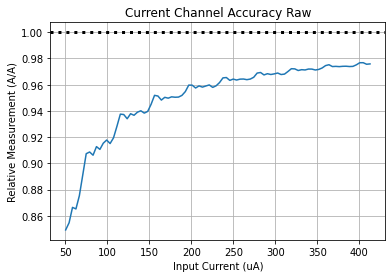

In [6]:
fig, ax = plot_accuracy(data["I_in"], data["I_meas"])

ax.set_title("Current Channel Accuracy Raw")
ax.set_xlabel("Input Current (uA)")
ax.set_ylabel("Relative Measurement (A/A)")

In [7]:
def calc_fit(x, y):
    """Calculates linear regression fit line given input x and output y.
    
    Parameters
    ----------
    x : Series
        input
    y : Series
        output
        
    Returns
    -------
    Series
        Fit line
    """
    
    linreg = stats.linregress(x, y)
    fit = linreg.intercept + x * linreg.slope
    return fit

In [8]:
# Linear Regression
data["V_fit"] = calc_fit(data["V_meas"], data["V_in"])
data["I_fit"] = calc_fit(data["I_meas"], data["I_in"])

Text(0, 0.5, 'Relative Measurement (V/V)')

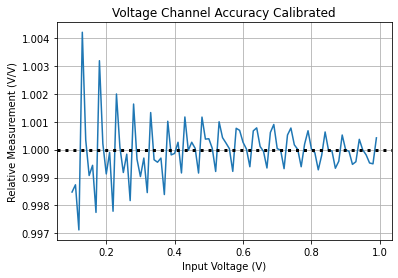

In [9]:
fig, ax = plot_accuracy(data["V_in"], data["V_fit"])

ax.set_title("Voltage Channel Accuracy Calibrated")
ax.set_xlabel("Input Voltage (V)")
ax.set_ylabel("Relative Measurement (V/V)")



Text(0, 0.5, 'Relative Measurement (A/A)')

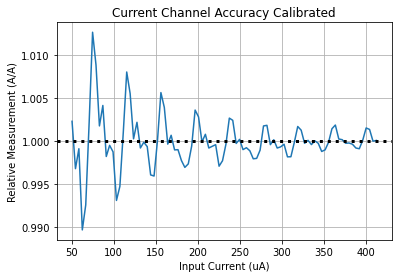

In [10]:
fig, ax = plot_accuracy(data["I_in"], data["I_fit"])

ax.set_title("Current Channel Accuracy Calibrated")
ax.set_xlabel("Input Current (uA)")
ax.set_ylabel("Relative Measurement (A/A)")


Text(0, 0.5, 'Nonlinearity (V)')

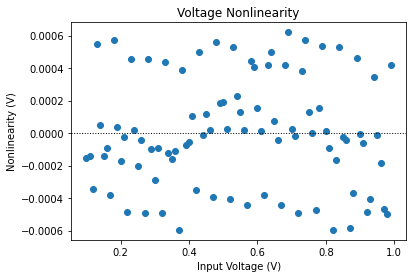

In [11]:
fig, ax = plt.subplots()
ax.scatter(data["V_in"], data["V_fit"] - data["V_in"])
ax.axhline(y=0, linestyle=':', color='k', linewidth='1')
ax.set_title("Voltage Nonlinearity")
ax.set_xlabel("Input Voltage (V)")
ax.set_ylabel("Nonlinearity (V)")

Text(0, 0.5, 'Nonlinearity (uA)')

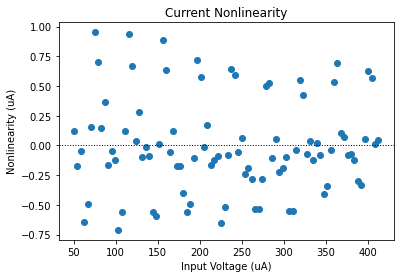

In [12]:
fig, ax = plt.subplots()
ax.scatter(data["I_in"], data["I_fit"] - data["I_in"])
ax.axhline(y=0, linestyle=':', color='k', linewidth='1')
ax.set_title("Current Nonlinearity")
ax.set_xlabel("Input Voltage (uA)")
ax.set_ylabel("Nonlinearity (uA)")